# Customer Retention Analysis

The Jupyter notebook is focused on performing customer retention analysis using a dataset from the R package SMCRM. The analysis is carried out using both a random forest regressor and a random forest classifier.

In [1]:
from main import CustomerRetention

## Data

The data used in this code snippet is from a CSV file located at 'acquisitionRetention.csv'. The features selected for analysis are:

* `acquisition`: binary feature indicating if the customer was acquired or not. This feature was removed from the classifier and regressor as the data was filtered to only include customers who were acquired.
* `duration`: duration of the customer's relationship with the company. This feature was removed from the classifier as it is not available at the time of acquisition.
* `profit`: profit generated by the customer.
* `acq_exp`: acquisition expenditure, the cost to acquire the customer.
* `ret_exp`: retention expenditure, the cost to retain the customer.
* `crossbuy`: number of different product categories purchased by the customer.
* `sow`: share of wallet, the proportion of the customer's total purchases made with the company.
* `industry`: the industry the customer belongs to.
* `freq`: frequency of purchases made by the customer.
* `revenue`: total revenue generated by the customer.
* `employees`: number of employees at the customer's company.
  
The features `acq_exp_sq`, `ret_exp_sq`, and `freq_sq` were removed from both the classifier and regressor as they are the square of other features and would add unnecessary complexity.

Note on the source: The `SMCRM` package provides a collection of datasets related to customer relationship management [1]. The "acquisitionRetention" dataset is one of the datasets included in this package, and contains information on customer acquisition and retention for a fictional company. The source of the data is not specified, but it was likely generated for the purpose of demonstrating analysis techniques related to customer relationship management.

[1] Smith, M. R., & Smythe, R. T. (2021). SMCRM: Data sets for statistical methods in customer relationship management by Kumar and Petersen (2012). R package version 1.0. Retrieved from https://CRAN.R-project.org/package=SMCRM

In [2]:
# Path to data
data_path = 'acquisitionRetention.csv'

# 'ret_exp','crossbuy','sow','freq','profit' removed from features in random forest classifier due to high cardinality with acquisition feature
features = [
    'acquisition', # removed from classifier and regressor (only used data filtered by acquisition == 1)
    'duration', # removed from classifier only
    'profit',
    # 'acq_exp_sq', # removed from classifier and regressor
    'acq_exp',
    # 'ret_exp_sq', # removed from classifier and regressor
    'ret_exp',
    'crossbuy',
    'sow',
    'industry',
    # 'freq_sq',  # removed from classifier and regressor
    'freq',
    'revenue',
    'employees'
]

# Create an instance of the CustomerRetention class
cr = CustomerRetention(data_path, features)

## Descriptive Statistics

Out of the 500 instances, 338 were acquired while 162 were not. The median duration of the acquired instances is higher (1072 days) than that of the not acquired instances (0 days). The median profit for the acquired instances is also higher (3713.5) than that of the not acquired instances (-472.0). The median acquisition expense is higher for the acquired instances (494.5) than the not acquired instances (472.0). Similarly, the median values of crossbuy, sow, and freq are higher for the acquired instances compared to the not acquired instances. For the industry feature, a higher percentage of the not acquired instances (65.4%) have industry data compared to the acquired instances (39.3%). The median revenue and employees for the not acquired instances are lower compared to the acquired instances.

In [3]:
df = cr.df

from tableone import TableOne

continuous_columns = ['duration', 'profit', 'acq_exp', 'ret_exp', 'crossbuy', 'sow', 'freq', 'revenue', 'employees']
categorical_columns = ['industry']
cols = categorical_columns + continuous_columns + ['acquisition']

df['acquisition'] = df['acquisition'].replace({1: 'Acquired', 0: 'Not Acquired'})

mytable = TableOne(
    df,
    columns=cols,
    nonnormal=continuous_columns,
    categorical=categorical_columns,
    groupby=['acquisition'])

print(mytable.tabulate(tablefmt="fancy_grid"))


╒═══════════════════════════╤════╤═══════════╤════════════════════════╤════════════════════════╤════════════════════════╕
│                           │    │ Missing   │ Overall                │ Acquired               │ Not Acquired           │
╞═══════════════════════════╪════╪═══════════╪════════════════════════╪════════════════════════╪════════════════════════╡
│ n                         │    │           │ 500                    │ 338                    │ 162                    │
├───────────────────────────┼────┼───────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│ industry, n (%)           │ 0  │ 0         │ 239 (47.8)             │ 133 (39.3)             │ 106 (65.4)             │
├───────────────────────────┼────┼───────────┼────────────────────────┼────────────────────────┼────────────────────────┤
│                           │ 1  │           │ 261 (52.2)             │ 205 (60.7)             │ 56 (34.6)              │
├───────────────────────

## K-fold Cross-Validation
These are performance metrics for a classifier and a regressor, respectively, obtained using 5-fold cross-validation on the available data. Cross-validation is a technique used to assess the performance of a model on unseen data by dividing the available data into k subsets, using k-1 subsets for training the model and the remaining subset for testing. This process is repeated k times with different subsets used for testing each time, and the performance metrics are averaged across all iterations.

For the classifier, the mean AUC (Area Under the ROC Curve) is 0.8648, which is a measure of how well the model can distinguish between the positive and negative classes. An AUC of 0.5 indicates a model that performs no better than random guessing, while an AUC of 1.0 indicates a perfect model that can perfectly separate the classes. An AUC of 0.8648 indicates that the classifier is performing relatively well.

For the regressor, the mean R2 score is 0.9651, which is a measure of how well the model fits the data. R2 score ranges from 0 to 1, where 0 indicates that the model is as good as predicting the mean of the target variable, and 1 indicates that the model can perfectly fit the data. An R2 score of 0.9651 indicates that the regressor is performing well and can explain a significant amount of the variance in the target variable.

In [4]:
cr.perform_k_fold_cross_validation()

Classifier 5-fold cross-validation mean AUC: 0.8648
Regressor 5-fold cross-validation mean R2 score: 0.9651


In [5]:
# Predict which customers will be acquired and for how long they will be retained
cr.predict_acquisition_and_duration()

## Optimized Hyperparameters 
* `max_depth`: None, which means that the decision trees in the forest can have unlimited depth.
* `min_samples_leaf`: 4, which is the minimum number of samples required to be at a leaf node.
* `min_samples_split`: 10, which is the minimum number of samples required to split an internal node.
* `n_estimators`: 100, which is the number of trees in the forest.

# Feature Importance
The feature importances, ranked in order of importance, are:

* `employees` (0.475378)
* `acq_exp` (0.236642)
* `revenue` (0.199761)
* `industry` (0.088219)
  
These importances indicate that the number of employees is the most important feature in predicting acquisition, followed by the acquisition expense, revenue, and industry. It is important to note that these importances are relative to each other and do not necessarily indicate the exact impact of each feature on the target variable.

In [6]:
# Compute variable importance to detect interactions and optimize hyperparameters for acquired customers.
cr.hyperparameter_optimization()

{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
1. employees (0.475378)
2. acq_exp (0.236642)
3. revenue (0.199761)
4. industry (0.088219)


## Model Performance
### Random Forest Regressor: *Predict duration of acquired customers*

* MSE (Mean Squared Error) is a measure of the average squared differences between the predicted and actual values. The mean MSE is 1194.96, with a 95% confidence interval of [625.54, 2088.50]. This indicates that, on average, the model's predicted values are off by around 1194.96, and that there is some variability in this error across different samples.
* MAE (Mean Absolute Error) is a measure of the average absolute differences between the predicted and actual values. The mean MAE is 24.44, with a 95% confidence interval of [19.01, 30.82]. This indicates that, on average, the model's predicted values are off by around 24.44, and that there is some variability in this error across different samples.
* R2 is a measure of how well the model fits the data, and ranges from 0 (worst fit) to 1 (perfect fit). The mean R2 is 0.978, with a 95% confidence interval of [0.961, 0.989]. This indicates that the model fits the data well, and that around 98% of the variation in the data can be explained by the model.

### Random Forest Classifier: *Predict acquired customer*

* Accuracy is a measure of the percentage of correct predictions. The mean accuracy is 0.86, with a 95% confidence interval of [0.79, 0.92]. This indicates that, on average, the model correctly predicts the class of around 86% of the samples.
* Recall is a measure of the percentage of true positives (i.e., correctly predicted positive samples) out of all actual positives. The mean recall is 0.94, with a 95% confidence interval of [0.884, 0.988]. This indicates that, on average, the model correctly predicts around 94% of the positive samples.
* Precision is a measure of the percentage of true positives out of all predicted positives. The mean precision is 0.87, with a 95% confidence interval of [0.779, 0.937]. This indicates that, on average, around 87% of the predicted positive samples are actually positive.
* AUROC (Area Under the Receiver Operating Characteristic Curve) is a measure of how well the model can distinguish between positive and negative samples, and ranges from 0.5 (worst performance) to 1 (perfect performance). The mean AUROC is 0.80, with a 95% confidence interval of [0.715, 0.890]. This indicates that the model is able to distinguish between positive and negative samples reasonably well, but there is some room for improvement.

In [7]:
# Compare the accuracy of the model with decision trees and logistic regression for acquiring customers.
cr.compare_models(model_type='regressor')
cr.compare_models(model_type='classifier')

            Mean                                        CI
MSE  1194.957868   [643.0483057720593, 2039.4408126838218]
MAE    24.444412   [18.619003676470594, 30.56832720588235]
R2      0.978045  [0.9611730735924104, 0.9880169780595404]
               Mean                                        CI
Accuracy   0.860000                              [0.79, 0.92]
Recall     0.942857  [0.8852301387137452, 0.9863013698630136]
Precision  0.868421  [0.7866666666666666, 0.9383655394524958]
AUROC      0.804762   [0.7147094324253471, 0.898558163920805]


## Model Interpretability

SHAP (SHapley Additive exPlanations) analysis and Partial Dependence Plots (PDPs) are two popular methods for explaining the behavior of machine learning models and gaining insights into the relationships between input features and the target variable.

Here are some similarities and differences between SHAP analysis and PDPs.

### Similarities:
* Both SHAP analysis and PDPs aim to provide explanations for the behavior of machine learning models.
* Both methods allow us to understand the importance and direction of the relationships between input features and the target variable.
* Both methods can help us identify non-linear relationships between input features and the target variable.

### Differences:
* PDPs show the average effect of an input feature on the predicted outcome, while SHAP values show the contribution of each input feature to the difference between the predicted outcome and the expected outcome.
* PDPs focus on the effect of a single input feature on the target variable, while SHAP values take into account the interactions between multiple input features.
* PDPs assume that all other input features are held constant, while SHAP values account for the effects of all input features in a given sample.
* PDPs can only show the effects of continuous input features, while SHAP values can be computed for both continuous and categorical input features.
* PDPs are easier to interpret and visualize than SHAP values, but SHAP values provide a more complete and accurate picture of the behavior of machine learning models.

In summary, SHAP analysis and PDPs are two complementary methods for explaining the behavior of machine learning models and understanding the relationships between input features and the target variable. **While PDPs are more straightforward to interpret and can provide valuable insights into the behavior of individual input features, SHAP values are more comprehensive and accurate and can capture the effects of multiple input features and their interactions.**

## Global Explanations

### Explaining Classification Predictions

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


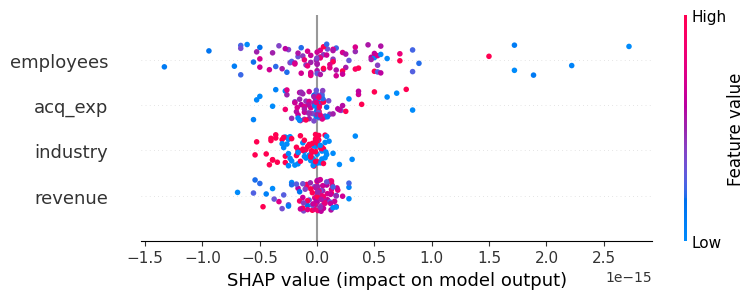

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

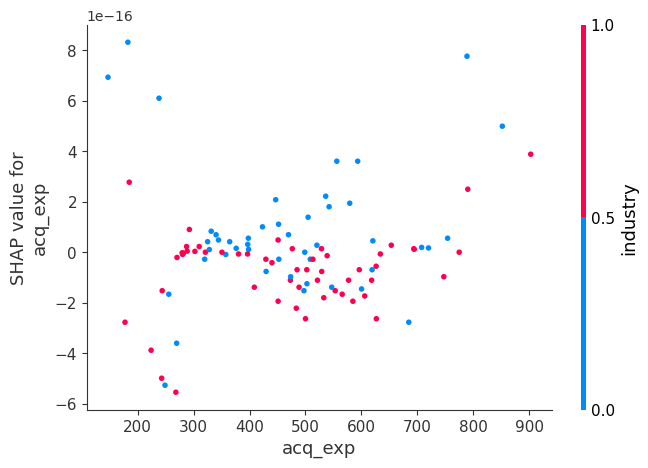

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

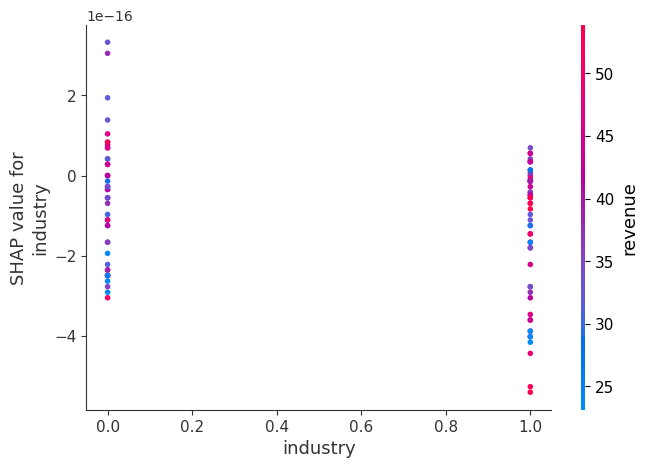

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

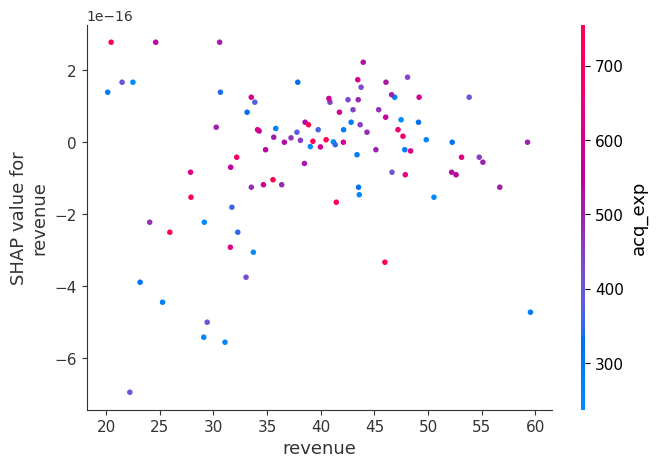

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

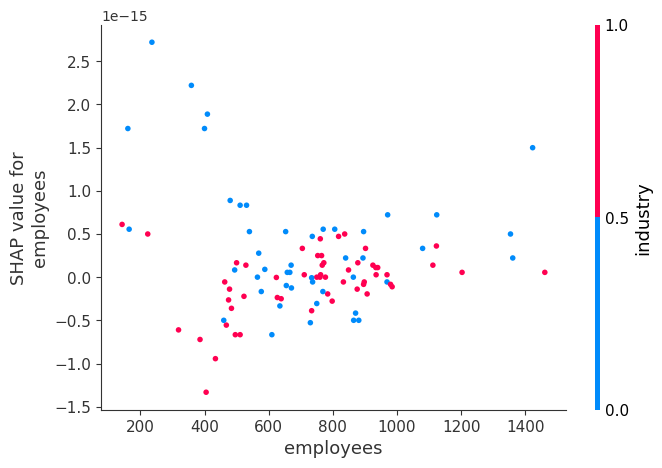

In [8]:
cr.shap_analysis(model_type='classifier')

### Explaining Regression Predictions

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


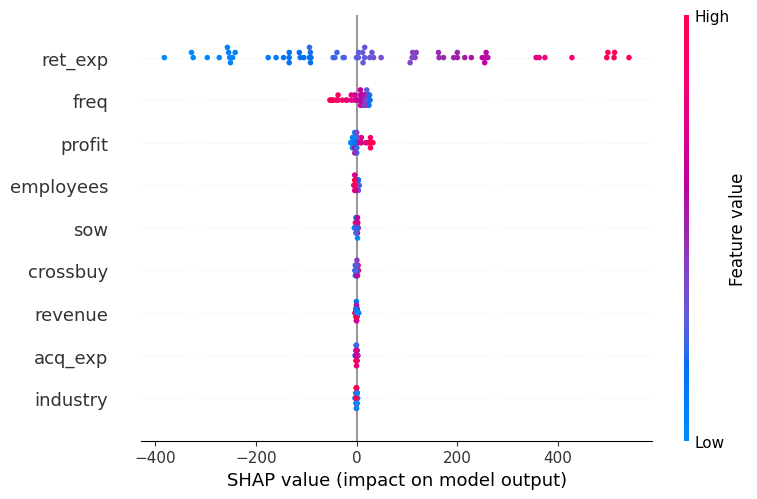

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

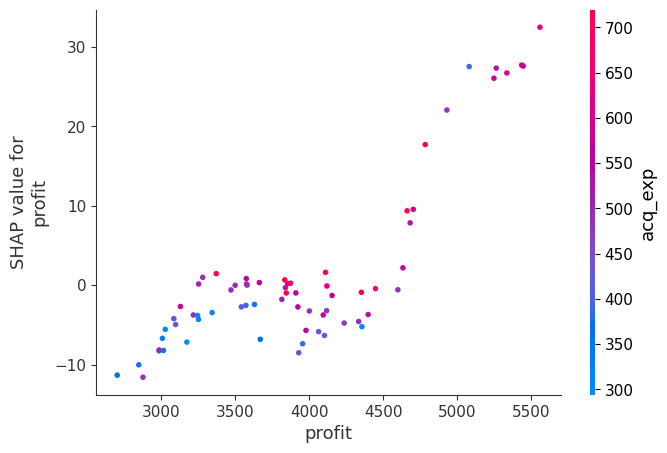

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

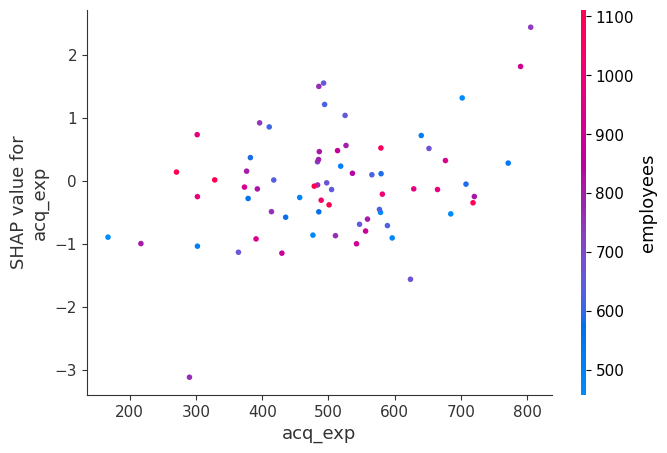

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

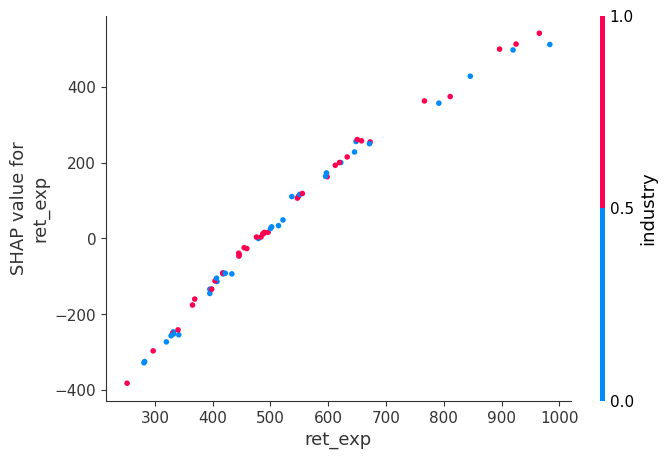

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

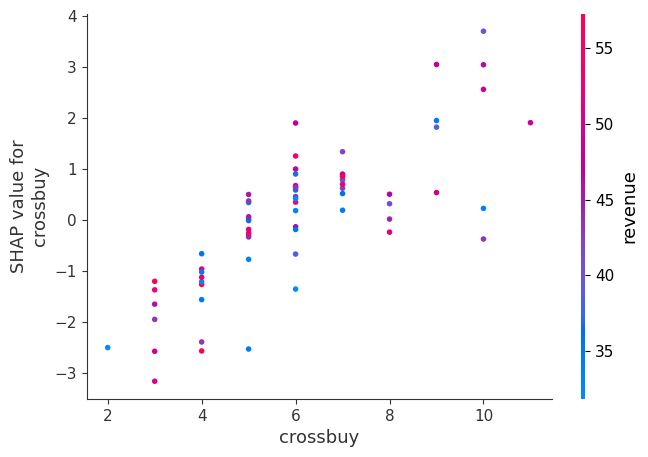

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

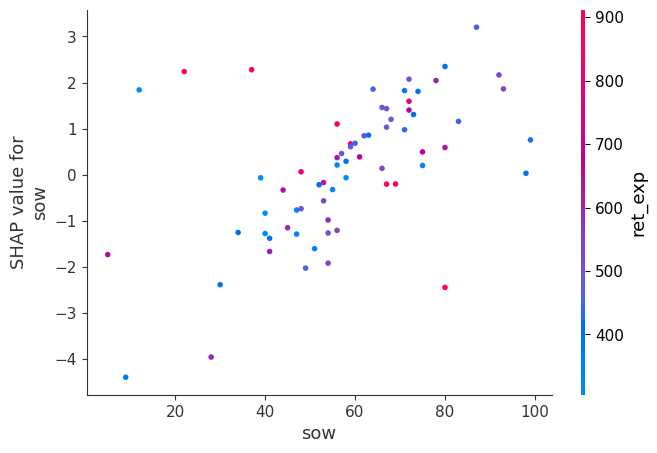

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

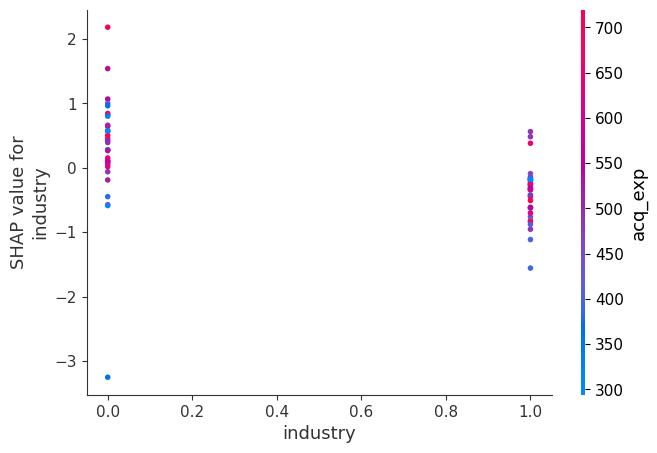

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

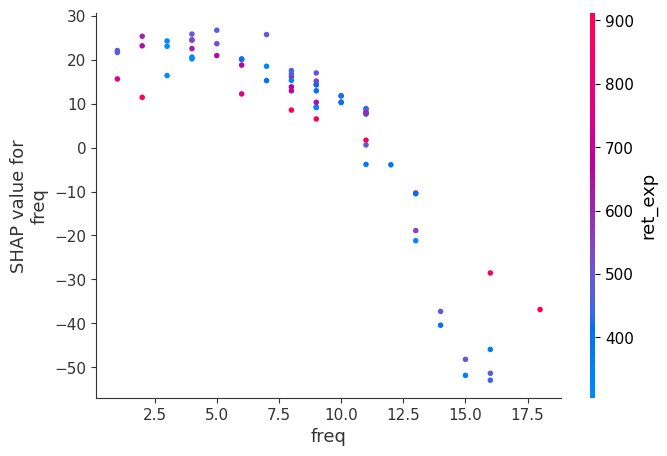

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

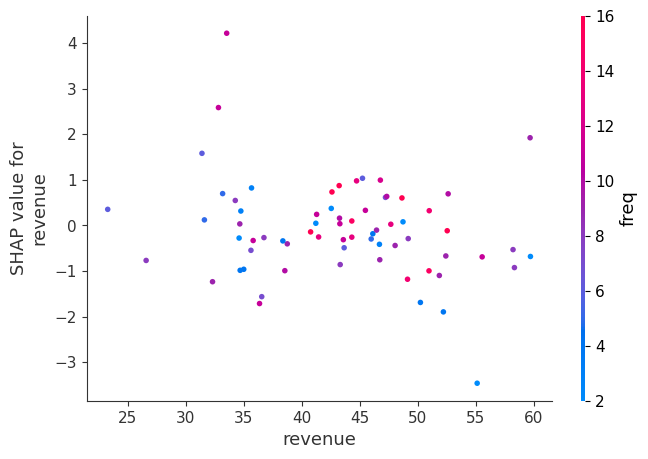

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

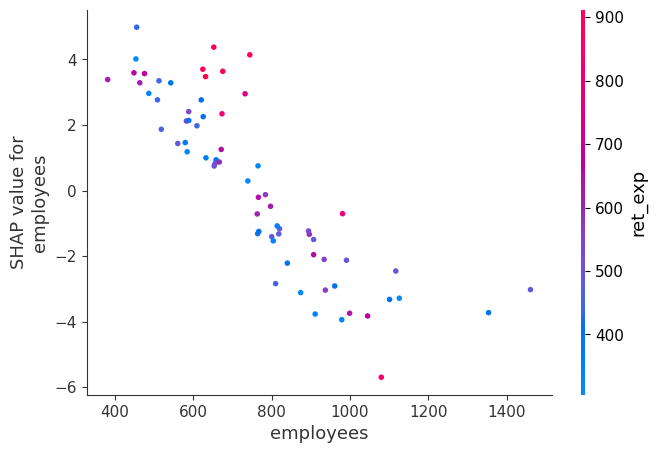

In [9]:
# Perform SHAP analysis and plot summary plot for both regressor and classifier
cr.shap_analysis(model_type='regressor')

## Local Explanations

Subject 0

Based on the SHAP explanations, we can see that the predicted duration is higher than the expected duration, which suggests that some of the features in the model are contributing to longer durations than expected.

Looking at the feature contributions, we can see that the "profit" feature has a positive contribution of 9.55 days, which suggests that higher profits are associated with longer durations. On the other hand, the "acq_exp" feature has a negative contribution of -0.90 days, which suggests that higher acquisition expenses are associated with shorter durations. The "ret_exp" feature has a positive contribution of 254.33 days, which suggests that higher retention expenses are associated with longer durations. Similarly, the "freq" feature has a positive contribution of 12.90 days, which suggests that higher frequency of purchases is associated with longer durations.

Overall, we can see that the model is capturing some of the factors that contribute to longer durations, such as higher profits, retention expenses, and purchase frequency, but it is also picking up on some factors that contribute to shorter durations, such as higher acquisition expenses. However, there may be other factors that the model is not capturing, which could explain the difference between the predicted and actual durations.

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Expected duration: 1091 days
Predicted duration: 1371 days
Actual duration: 1382 days

                      Value  Contribution
Feature                                  
profit              4703.88      9.545458
acq_exp              596.18     -0.903431
ret_exp               672.6    254.328317
crossbuy                6.0      0.674852
sow                    61.0      0.388002
industry                1.0     -0.334528
freq                    8.0     12.901957
revenue               49.17     -0.290063
employees             475.0      3.567473
Expected duration             1091.971963
Predicted duration            1371.850000


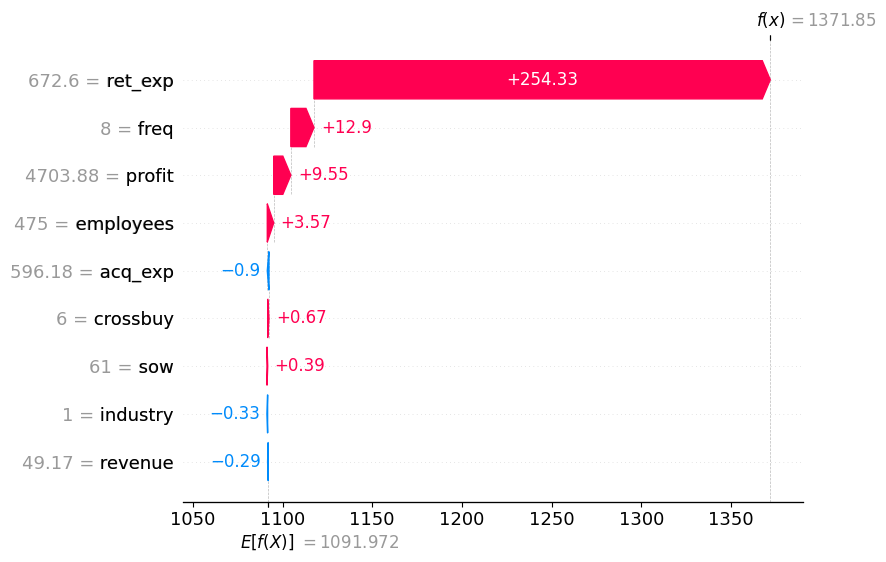

In [10]:
import shap
import pandas as pd

shap.initjs()

explainer = shap.Explainer(cr.rf_dur)
shap_values = explainer(cr.X_test_dur)

# Select the index of the instance you want to explain
instance_index = 0

# Get the SHAP values and expected value for the selected instance
instance_shap_values = shap_values[instance_index].values
expected_value = explainer.expected_value[0]  # Corrected line: access the scalar value from the array

# Create an Explanation object
explanation = shap.Explanation(values=instance_shap_values, base_values=expected_value, data=cr.X_test_dur.iloc[instance_index], feature_names=cr.X_test_dur.columns)

# Print the actual, expected, and predicted durations for the selected instance
actual_value = cr.y_test_dur.iloc[instance_index]
predicted_value = cr.rf_dur.predict(cr.X_test_dur)[instance_index]

print(f"Expected duration: {int(expected_value)} days")
print(f"Predicted duration: {int(predicted_value)} days")
print(f"Actual duration: {int(actual_value)} days")
print("")

# Create lists of the feature names, feature values, and feature contributions
features = []
values = []
contributions = []
for feature, value, contribution in zip(explanation.feature_names, explanation.data, explanation.values):
    features.append(feature)
    values.append(value)
    contributions.append(contribution)

# Add a row for the expected value
features.append("Expected duration")
values.append("")
contributions.append(expected_value)

# Add a row for the predicted value
features.append("Predicted duration")
values.append("")
contributions.append(predicted_value)

# Create a DataFrame from the lists and print it
table = pd.DataFrame({"Feature": features, "Value": values, "Contribution": contributions})
table.set_index("Feature", inplace=True)
print(table)

# Plot the waterfall plot
shap.waterfall_plot(explanation, max_display=10)